In [ ]:
import os
import shutil

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from google.colab import drive
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
from torchvision import datasets, transforms
from tqdm import tqdm

device = 'cuda'
drive.mount('/content/drive')
DRIVE_CHECKPOINT_DIR = '/content/drive/MyDrive/CIFAR10-model5-training'
# os.makedirs(DRIVE_CHECKPOINT_DIR, exist_ok=True)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_channels, out_channels, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.conv3 = nn.Conv2d(out_channels, out_channels * self.expansion, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels * self.expansion)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels * self.expansion:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels * self.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * self.expansion)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)

        return out

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_channels = 64

        # conv
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)

        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)

        # classification
        self.linear = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, out_channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])

def ResNet34():
    return ResNet(BasicBlock, [3, 4, 6, 3])

def ResNet50():
    return ResNet(Bottleneck, [3, 4, 6, 3])

def ResNet101():
    return ResNet(Bottleneck, [3, 4, 23, 3])

def ResNet152():
    return ResNet(Bottleneck, [3, 8, 36, 3])

In [ ]:
# from resnet import ResNet152

torch.manual_seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


def get_data_loaders(batch_size=128, num_workers=2):
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])

    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])

    trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

    testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
    testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=num_workers)

    classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

    return trainloader, testloader, classes


def train(model, trainloader, criterion, optimizer, scheduler, epoch):
    model.train()
    train_loss = 0
    correct = 0
    total = 0

    loop = tqdm(trainloader, desc=f"Epoch {epoch + 1}")
    for batch_idx, (inputs, targets) in enumerate(loop):
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

        loop.set_postfix(loss=train_loss / (batch_idx + 1), acc=100. * correct / total)

    scheduler.step()

    return train_loss / len(trainloader), 100. * correct / total


def val(model, testloader, criterion):
    model.eval()
    test_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, targets in testloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    return test_loss / len(testloader), 100.0 * correct / total


def main():
    num_epochs = 100
    batch_size = 128
    lr = 0.05
    T_0 = 10
    T_mult = 2

    os.makedirs('results', exist_ok=True)

    trainloader, testloader, classes = get_data_loaders(batch_size)

    model = ResNet152().to(device)
    print(f"Created ResNet152 model with {sum(p.numel() for p in model.parameters())} parameters")

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)

    scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=T_0, T_mult=T_mult, eta_min=1e-5)

    start_epoch = 0
    if os.path.exists('/content/drive/MyDrive/CIFAR10-model5-training/resnet152_checkpoint_epoch_58.pt'):
        checkpoint = torch.load('/content/drive/MyDrive/CIFAR10-model5-training/resnet152_checkpoint_epoch_58.pt')
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        start_epoch = checkpoint['epoch'] + 1
        print(f"Resuming from epoch {start_epoch}")

    train_losses = []
    test_losses = []
    train_accs = []
    test_accs = []
    best_acc = 0

    for epoch in range(start_epoch, num_epochs):
        train_loss, train_acc = train(model, trainloader, criterion, optimizer, scheduler, epoch)
        train_losses.append(train_loss)
        train_accs.append(train_acc)

        test_loss, test_acc = val(model, testloader, criterion)
        test_losses.append(test_loss)
        test_accs.append(test_acc)

        print(f'\nEpoch {epoch + 1}/{num_epochs}:')
        print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
        print(f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%')

        # Save checkpoint
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'train_loss': train_loss,
            'test_loss': test_loss,
            'train_acc': train_acc,
            'test_acc': test_acc
        }, 'results/resnet152_checkpoint.pt')

        # Save checkpoint to Google Drive
        drive_checkpoint_path = f'{DRIVE_CHECKPOINT_DIR}/resnet152_checkpoint_epoch_{epoch+1}.pt'
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'train_loss': train_loss,
            'test_loss': test_loss,
            'train_acc': train_acc,
            'test_acc': test_acc
        }, drive_checkpoint_path)
        print(f'Checkpoint saved to Google Drive: resnet152_checkpoint_epoch_{epoch+1}.pt')

        latest_drive_checkpoint_path = f'{DRIVE_CHECKPOINT_DIR}/resnet152_checkpoint_latest.pt'
        shutil.copy2(drive_checkpoint_path, latest_drive_checkpoint_path)

        # Save best model
        if test_acc > best_acc:
            best_acc = test_acc
            # Save to local directory
            torch.save(model.state_dict(), 'results/resnet152_best.pt')

            # Save to Google Drive
            best_drive_path = f'{DRIVE_CHECKPOINT_DIR}/resnet152_best.pt'
            torch.save(model.state_dict(), best_drive_path)
            print(f'New best model saved to Google Drive! (Accuracy: {test_acc:.2f}%)')

        if epoch % 10 == 0:
            lrs = scheduler.get_last_lr()
            print(f'Current LR: {lrs[0]:.6f}')

        if (epoch + 1) % 10 == 0 or epoch == num_epochs - 1:
            plt.figure(figsize=(12, 5))

            plt.subplot(1, 2, 1)
            plt.plot(train_losses, label='Train Loss')
            plt.plot(test_losses, label='Test Loss')
            plt.title('Loss vs. Epochs')
            plt.xlabel('Epochs')
            plt.ylabel('Loss')
            plt.legend()

            plt.subplot(1, 2, 2)
            plt.plot(train_accs, label='Train Accuracy')
            plt.plot(test_accs, label='Test Accuracy')
            plt.title('Accuracy vs. Epochs')
            plt.xlabel('Epochs')
            plt.ylabel('Accuracy (%)')
            plt.legend()

            plt.tight_layout()
            plt.savefig(f'results/training_curves_epoch_{epoch + 1}.png')
            plt.close()

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(test_losses, label='Test Loss')
    plt.title('Loss vs. Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Train Accuracy')
    plt.plot(test_accs, label='Test Accuracy')
    plt.title('Accuracy vs. Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    plt.tight_layout()
    plt.savefig('results/final_training_curves.png')
    plt.show()

    print(f'Best accuracy: {best_acc:.2f}%')


if __name__ == '__main__':
    main()

Evaluating: 100%|██████████| 100/100 [00:20<00:00,  4.84it/s]


Accuracy: 94.47%
Saving 100 misclassified examples to ./misclassifications...
Misclassifications summary saved to ./misclassifications/misclassifications_summary.txt
Misclassified examples grid saved to ./misclassifications/misclassified_examples.png
Additional visualizations saved to ./misclassifications/


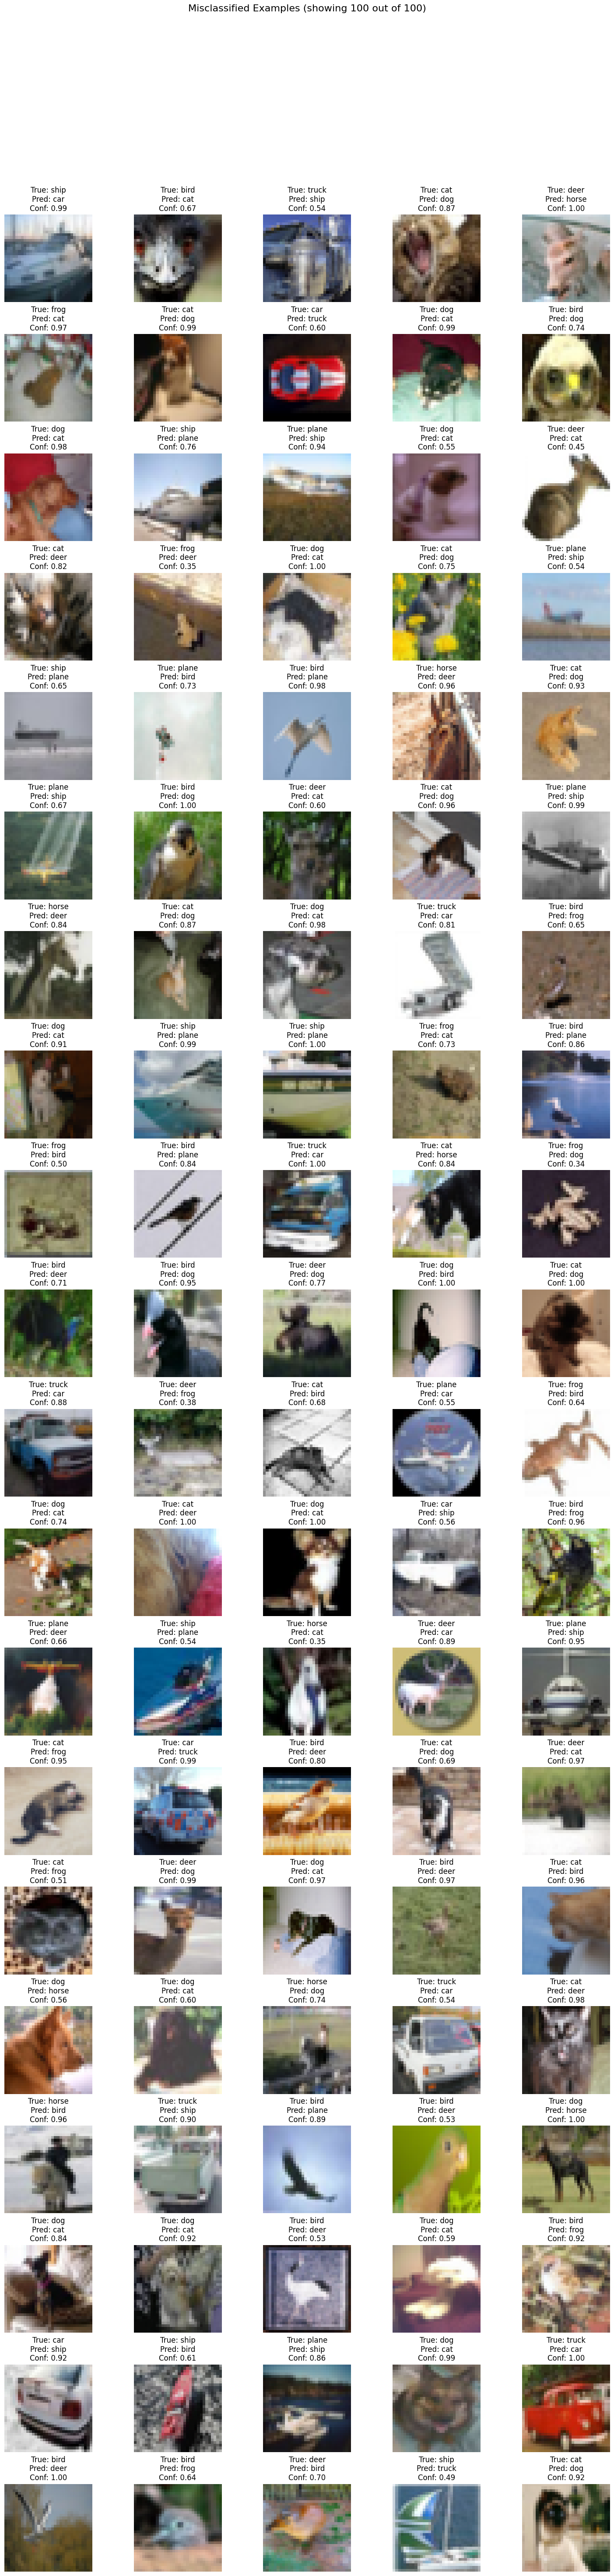

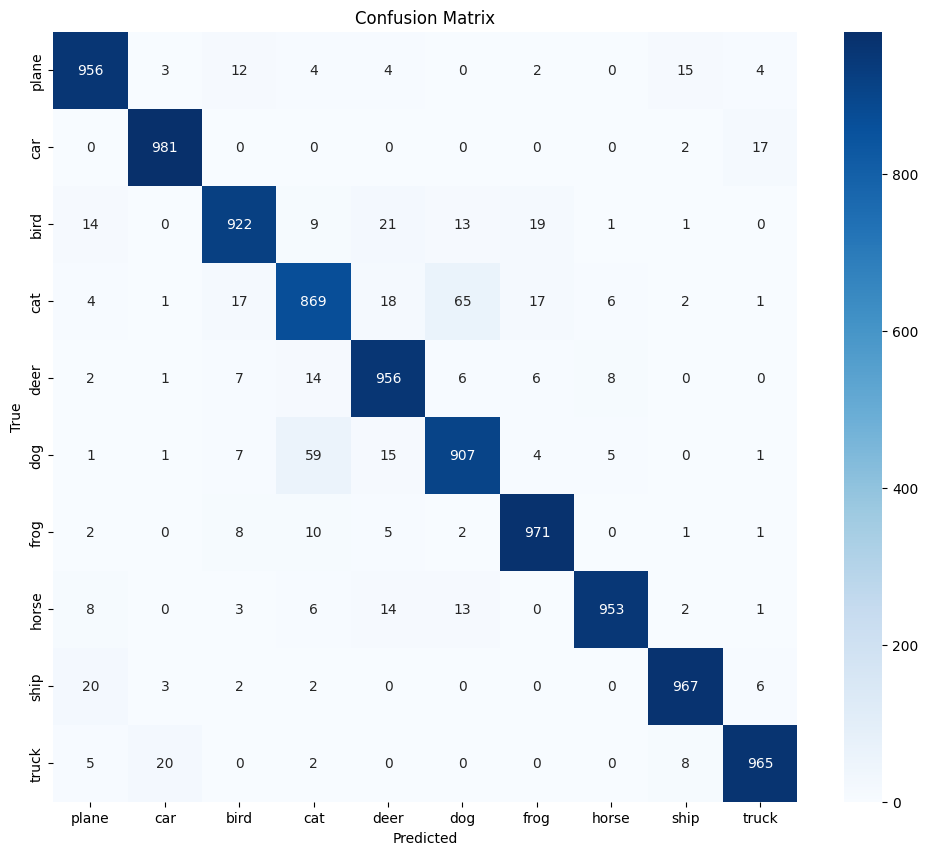

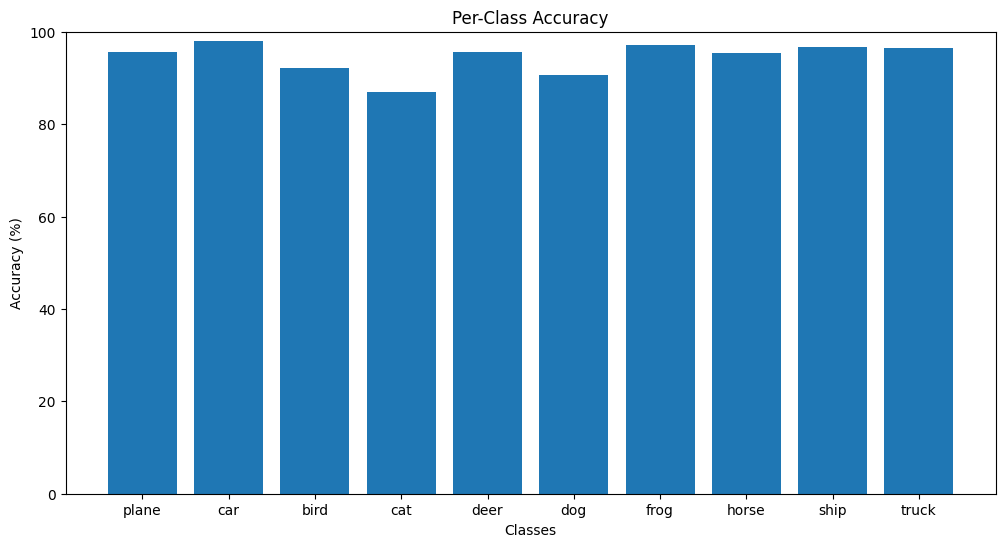

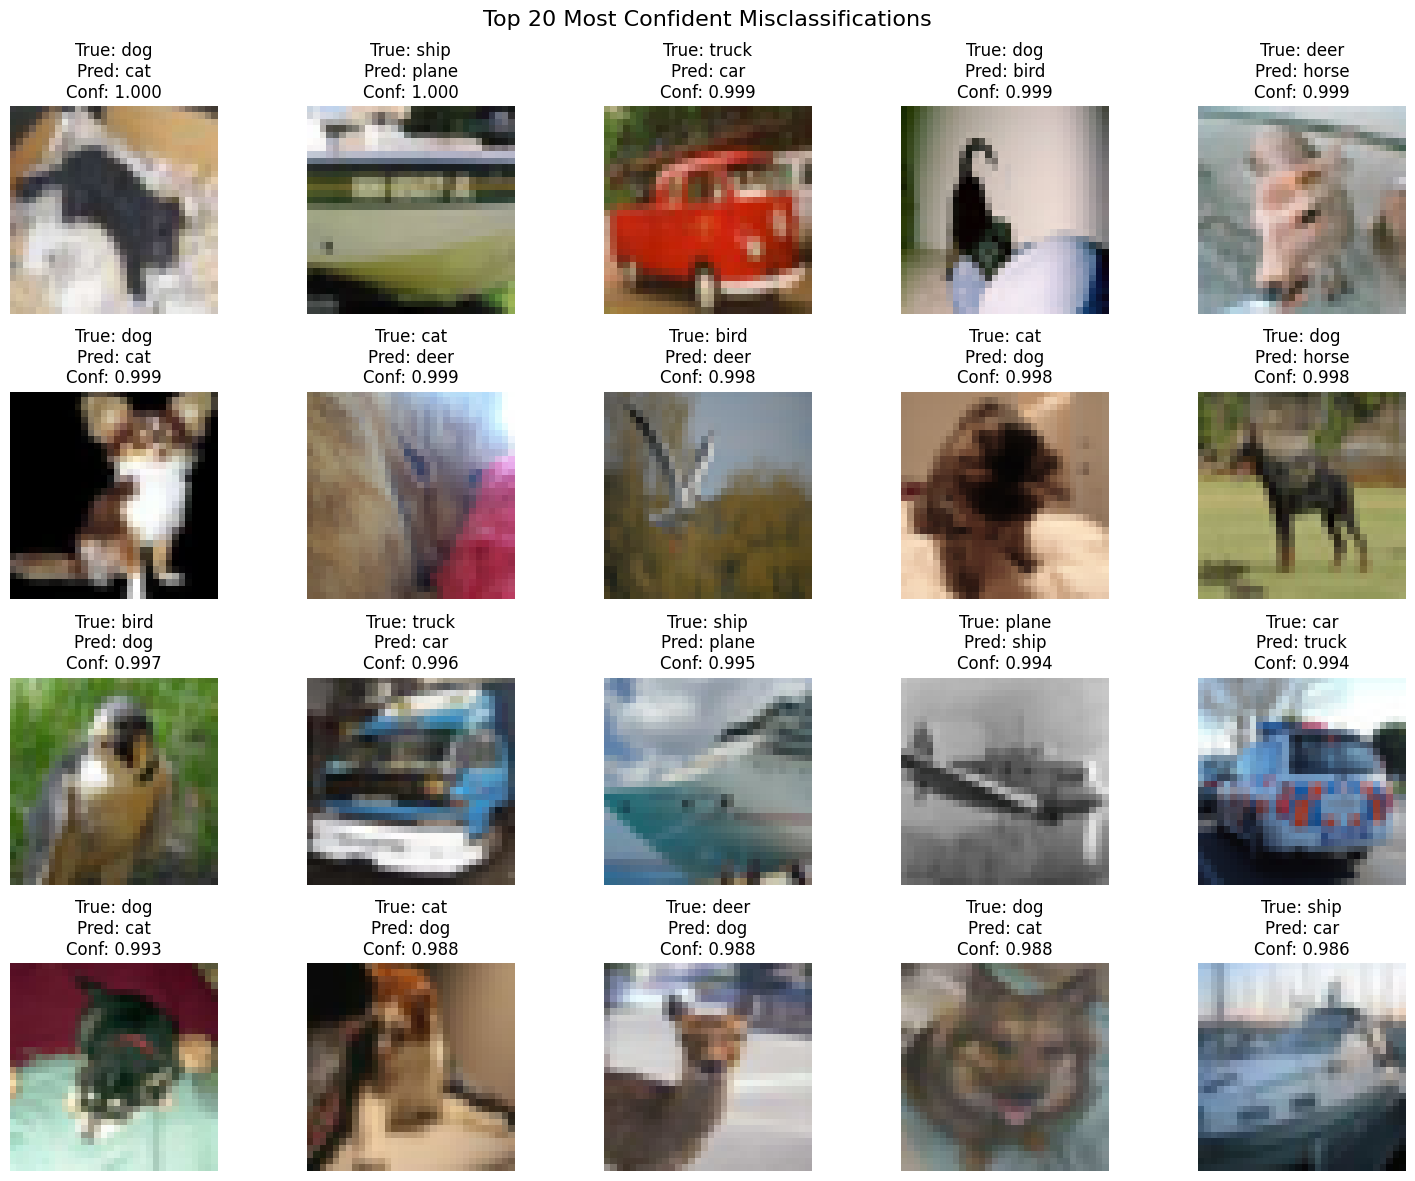

In [ ]:
def evaluate_model(modelPath, outputDir='./', max_examples=100):

    if not os.path.exists(outputDir):
        os.makedirs(outputDir)

    # Normalization
    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])

    testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
    testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

    classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

    model = ResNet152()

    state_dict = torch.load(modelPath, map_location=device)
    model.load_state_dict(state_dict)
    model = model.to(device)
    model.eval()

    misclassified_images = []
    misclassified_predictions = []
    misclassified_labels = []
    misclassified_confidences = []

    all_predictions = []
    all_targets = []

    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in tqdm(testloader, desc='Evaluating'):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_predictions.extend(predicted.cpu().numpy())
            all_targets.extend(labels.cpu().numpy())

            misclassified_indices = (predicted != labels).nonzero(as_tuple=True)[0]

            for idx in misclassified_indices:
                if len(misclassified_images) < max_examples:
                    misclassified_images.append(images[idx].cpu())
                    misclassified_predictions.append(predicted[idx].item())
                    misclassified_labels.append(labels[idx].item())

                    # Get probability
                    softmax_probs = torch.nn.functional.softmax(outputs[idx], dim=0)
                    confidence = softmax_probs[predicted[idx]].item()
                    misclassified_confidences.append(confidence)

    accuracy = 100 * correct / total
    print(f'Accuracy: {accuracy:.2f}%')

    print(f'Saving {len(misclassified_images)} misclassified examples to {outputDir}...')

    with open(f'{outputDir}/misclassifications_summary.txt', 'w', encoding='utf-8') as f:
        f.write(f'Total accuracy: {accuracy:.2f}%\n')
        f.write(f'Total misclassifications: {total - correct} out of {total}\n\n')
        f.write('Class-wise misclassifications:\n')

        class_correct = [0] * 10
        class_total = [0] * 10

        for i in range(len(all_targets)):
            label = all_targets[i]
            class_total[label] += 1
            if all_predictions[i] == label:
                class_correct[label] += 1

        for i in range(10):
            class_acc = 100 * class_correct[i] / class_total[i]
            f.write(f'{classes[i]}: {class_acc:.2f}% correct ({class_correct[i]} out of {class_total[i]})\n')

        f.write('\nTop confusion pairs (true → predicted):\n')
        confusion = {}
        for true, pred in zip(all_targets, all_predictions):
            if true != pred:
                key = (true, pred)
                confusion[key] = confusion.get(key, 0) + 1
                confusion[key] = confusion.get(key, 0) + 1

        top_confusions = sorted(confusion.items(), key=lambda x: x[1], reverse=True)[:10]
        for (true, pred), count in top_confusions:
            f.write(f'{classes[true]} → {classes[pred]}: {count} times\n')

    ncols = 5
    nrows = min(len(misclassified_images) // ncols + (1 if len(misclassified_images) % ncols != 0 else 0), 20)

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 3 * nrows))
    fig.suptitle(f'Misclassified Examples (showing {nrows * ncols} out of {len(misclassified_images)})', fontsize=16)

    # Denormalize images
    def denormalize(tensor):
        mean = torch.tensor([0.4914, 0.4822, 0.4465]).view(3, 1, 1)
        std = torch.tensor([0.2023, 0.1994, 0.2010]).view(3, 1, 1)
        return tensor * std + mean

    for i, ax in enumerate(axes.flat):
        if i < len(misclassified_images):
            img = denormalize(misclassified_images[i])
            img = np.transpose(img.numpy(), (1, 2, 0))
            img = np.clip(img, 0, 1)

            ax.imshow(img)
            ax.set_title(
                f'True: {classes[misclassified_labels[i]]}\nPred: {classes[misclassified_predictions[i]]}\nConf: {misclassified_confidences[i]:.2f}')
            ax.axis('off')
        else:
            ax.axis('off')

    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.savefig(f'{outputDir}/misclassified_examples.png', dpi=300, bbox_inches='tight')

    print(f'Misclassifications summary saved to {outputDir}/misclassifications_summary.txt')
    print(f'Misclassified examples grid saved to {outputDir}/misclassified_examples.png')


    from sklearn.metrics import confusion_matrix
    import seaborn as sns

    cm = confusion_matrix(all_targets, all_predictions)
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.savefig(f'{outputDir}/confusion_matrix.png', dpi=300, bbox_inches='tight')

    class_accuracies = [100 * class_correct[i] / class_total[i] for i in range(10)]
    plt.figure(figsize=(12, 6))
    plt.bar(classes, class_accuracies)
    plt.xlabel('Classes')
    plt.ylabel('Accuracy (%)')
    plt.title('Per-Class Accuracy')
    plt.ylim(0, 100)
    plt.savefig(f'{outputDir}/per_class_accuracy.png', dpi=300, bbox_inches='tight')

    if len(misclassified_images) > 0:
        sorted_indices = np.argsort(misclassified_confidences)[::-1]
        top_confident_misclassifications = [(misclassified_labels[i],
                                             misclassified_predictions[i],
                                             misclassified_confidences[i],
                                             misclassified_images[i])
                                            for i in sorted_indices[:20]]

        fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(15, 12))
        fig.suptitle('Top 20 Most Confident Misclassifications', fontsize=16)

        for i, (label, pred, conf, img) in enumerate(top_confident_misclassifications):
            if i < 20:
                ax = axes[i // 5, i % 5]
                img = denormalize(img)
                img = np.transpose(img.numpy(), (1, 2, 0))
                img = np.clip(img, 0, 1)
                ax.imshow(img)
                ax.set_title(f'True: {classes[label]}\nPred: {classes[pred]}\nConf: {conf:.3f}')
                ax.axis('off')

        plt.tight_layout()
        plt.subplots_adjust(top=0.9)
        plt.savefig(f'{outputDir}/top_confident_misclassifications.png', dpi=300, bbox_inches='tight')

    print(f'Additional visualizations saved to {outputDir}/')

    return {
        'accuracy': accuracy,
        'misclassified_images': misclassified_images,
        'misclassified_predictions': misclassified_predictions,
        'misclassified_labels': misclassified_labels,
        'misclassified_confidences': misclassified_confidences,
        'classes': classes
    }


if __name__ == '__main__':
    modelPath = f'{DRIVE_CHECKPOINT_DIR}/resnet152_best.pt'
    outputDir = './misclassifications'

    evaluate_model(modelPath, outputDir)